In [79]:
# Import modules and subroutines:
include("../subroutines/Subroutines.jl");

3.10.9


In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h6_0.95A_sto-3g_052323%1850.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h6_0.95A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/0.95.xyz
RHF energy: -2.5522990394405527
FCI energy: -2.7708424728855965


In [3]:
fci_array = FCIArray(chemical_data)
fci_mps = MPS(fci_array, siteinds("Electron", 6), cutoff=1e-16, maxdim=2^16);

6×6 Matrix{Float64}:
 0.0        0.0278427  0.0283161  0.0466484  0.122947   0.0670874
 0.0278427  0.0        0.840717   0.75811    0.0453651  0.132915
 0.0283161  0.840717   0.0        0.536576   0.134468   0.123869
 0.0466484  0.75811    0.536576   0.0        0.0788429  0.157981
 0.122947   0.0453651  0.134468   0.0788429  0.0        0.147736
 0.0670874  0.132915   0.123869   0.157981   0.147736   0.0

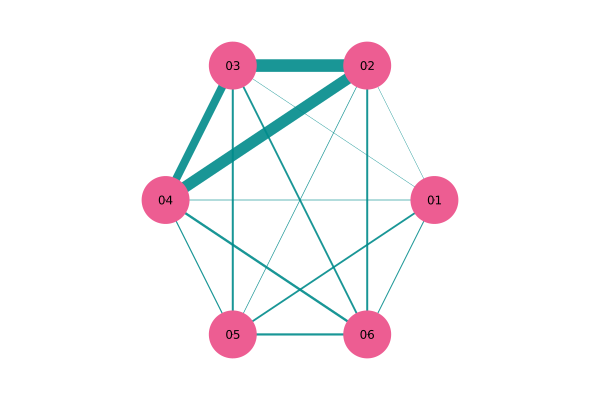

In [4]:
S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data)

display(Ipq)

OrbitalGraphPlot(Ipq, multiplier=1.5e1)

In [37]:
gp = GeomParameters(
    maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=1e0
)

op1 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="projection", 
    sd_eps=1.0e-7,
    delta=[0.0],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.99999,
    sd_dtol=5e-2,
    sd_etol=0.003
)

op2 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="projection", 
    sd_eps=1.0e-7,
    delta=[0.0],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.999,
    sd_dtol=5e-2,
    sd_etol=0.002,
    swap_mult=2.0
)

op3 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="projection", 
    sd_eps=1.0e-7,
    delta=[0.0],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.9999,
    sd_dtol=5e-2,
    sd_etol=0.001,
    swap_mult=1.0
)

op4 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="projection", 
    sd_eps=1.0e-7,
    delta=[0.0],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.9999,
    sd_dtol=5e-2,
    sd_etol=0.0005,
    swap_mult=0.0
)

op_list = [op1, op2, op3, op4]

4-element Vector{OptimParameters}:
 OptimParameters(1, 1, -1, [0.0], [0.0], 0.0, 10.0, 1.0, "inversion", 1.0e-8, "triple_geneig", "projection", 1.0e-7, 3, 0.99999, 0.99999, 0.05, 0.003)
 OptimParameters(1, 1, -1, [0.0], [0.0], 0.0, 10.0, 2.0, "inversion", 1.0e-8, "triple_geneig", "projection", 1.0e-7, 3, 0.99999, 0.999, 0.05, 0.002)
 OptimParameters(1, 1, -1, [0.0], [0.0], 0.0, 10.0, 1.0, "inversion", 1.0e-8, "triple_geneig", "projection", 1.0e-7, 3, 0.99999, 0.9999, 0.05, 0.001)
 OptimParameters(1, 1, -1, [0.0], [0.0], 0.0, 10.0, 0.0, "inversion", 1.0e-8, "triple_geneig", "projection", 1.0e-7, 3, 0.99999, 0.9999, 0.05, 0.0005)

In [19]:
nomps0 = GenSubspace(chemical_data, 4, psi_maxdim=4, thresh="projection", eps=1e-12, sweep_num=8, sweep_noise=(1e-2));

opt_ord = InfDistAnnealing(
    Ipq, 
    1, 
    gp,
    verbose=true
)[1]

#opt_ord = [1,2,3,4,5,6]

nomps0.ord_list = [deepcopy(opt_ord) for i=1:nomps0.mparams.M]

GenHams!(nomps0)
GenStates!(nomps0, ovlp_opt=true, weight=2.0, verbose=true)
#nomps0.psi_list[end] = dmrg(nomps0.ham_list[end], nomps0.psi_list[end], nomps0.dflt_sweeps)[2]
#nomps0.psi_list = reverse(nomps0.psi_list)
GenPermOps!(nomps0)
GenSubspaceMats!(nomps0)
SolveGenEig!(nomps0)

Generating states:    
Progress: [4/4] 
Done!


In [8]:
CountNonZeros(nomps0.psi_list)

197

In [66]:
CountNonZeros(dmrg10.psi_list)

LoadError: UndefVarError: dmrg10 not defined

In [70]:
println(chemical_data.e_fci - chemical_data.e_nuc)

-8.332930207486642


In [20]:
nomps1 = copy(nomps0)

"""
for k=1:4

    SeedNoise!(
        nomps1,
        0.1,
        0.1,
        penalty=0.0
    )
    
    TwoSitePairSweep!(
        nomps1,
        op_list[2],
        verbose=true
    )
    
end
"""

TwoSitePairSweep!(
    nomps1,
    op_list[2],
    verbose=true
)

TwoSitePairSweep!(
    nomps1,
    op_list[2],
    verbose=true
)


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 5/5; E_min = -8.31985; Delta = 0.01308; kappa = 1.44     
Done!


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 5/5; E_min = -8.3248; Delta = 0.00814; kappa = 1.32      
Done!



In [80]:
tnqe1 = copy(nomps1)

noise_list = [0.005, 0.005, 0.005, 0.005]
penalty_list = [0.999, 0.9999, 0.9999, 0.9999]
nt_list = [3,3,3,3]

for s=1:4

    for k=1:10
        
        ShuffleStates!(tnqe1)
        
        SeedNoise!(
            tnqe1,
            noise_list[s],
            0.0,
            #jset=[j_idx],
            penalty=0.999
        )

        AllStateFSWAP!(
            tnqe1,
            op_list[s],
            no_swap=false,
            n_twos=nt_list[s],
            verbose=true
        )

    end
    
    println("\n----\n")
    
end


FSWAP DISENTANGLER:
Sweep: 1/1; orbital: 6/6; #swaps: 5; E_min = -8.32368; Delta = 0.00925; kappa_full = 8.48e15; kappa_disc = 1.55; kappa = 1.27      
Done!


FSWAP DISENTANGLER:
Sweep: 1/1; orbital: 6/6; #swaps: 3; E_min = -8.32522; Delta = 0.00771; kappa_full = 4.37; kappa_disc = 4.37; kappa = 2.25     4     
Done!


FSWAP DISENTANGLER:
Sweep: 1/1; orbital: 6/6; #swaps: 4; E_min = -8.32723; Delta = 0.0057; kappa_full = 989.0; kappa_disc = 8.83; kappa = 1.08        
Done!


FSWAP DISENTANGLER:
Sweep: 1/1; orbital: 6/6; #swaps: 3; E_min = -8.32834; Delta = 0.00459; kappa_full = 32700.0; kappa_disc = 32700.0; kappa = 1.08     
Done!


FSWAP DISENTANGLER:
Sweep: 1/1; orbital: 6/6; #swaps: 4; E_min = -8.32617; Delta = 0.00676; kappa_full = 37000.0; kappa_disc = 37000.0; kappa = 1.57     
Done!


FSWAP DISENTANGLER:
Sweep: 1/1; orbital: 6/6; #swaps: 4; E_min = -8.32712; Delta = 0.00581; kappa_full = NaN; kappa = 1.37     4.5; kappa = 1.37         
Done!


FSWAP DISENTANGLER:
Sweep: 1/1; 

LoadError: InterruptException:

In [81]:

TwoSitePairSweep!(
    tnqe1,
    op_list[2],
    verbose=true
)

OneSitePairSweep!(
    tnqe1,
    op_list[1],
    verbose=true
)


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 5/5; E_min = -8.33194; Delta = 0.00099; kappa = 1.91     
Done!


TWO-STATE, ONE-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 8/8; sweep: 1/1; bond: 6/6; E_min = -8.33202; Delta = 0.00091; kappa = 1.96     
Done!



In [74]:
display(tnqe1.C)

4×4 Matrix{Float64}:
 1.23758    3.29741     -0.136367  -0.11569
 1.9829     2.82432     -0.773306   0.0468268
 0.244731  -0.0292951    0.945978  -0.664379
 0.12359    0.00115394   0.166694   1.07555

In [75]:
op_list[2]

OptimParameters
  maxiter: Int64 1
  numloop: Int64 1
  numopt: Int64 -1
  noise: Array{Float64}((1,)) [0.0]
  delta: Array{Float64}((1,)) [0.0]
  theta: Float64 0.0
  ttol: Float64 10.0
  swap_mult: Float64 2.0
  thresh: String "inversion"
  eps: Float64 1.0e-8
  sd_method: String "triple_geneig"
  sd_thresh: String "projection"
  sd_eps: Float64 1.0e-7
  sd_reps: Int64 3
  sd_penalty: Float64 0.99999
  sd_swap_penalty: Float64 0.9999
  sd_dtol: Float64 0.001


In [76]:
-7.77346*0.99

-7.6957254

In [77]:
tnqe1.E[1]+chemical_data.e_nuc

-2.7573204765189105

EXCITATION LEVEL: 0


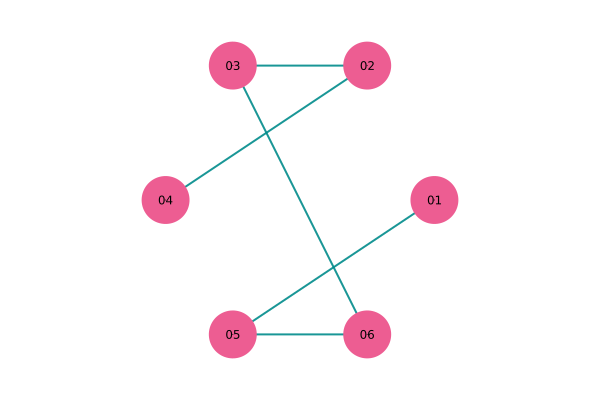

EXCITATION LEVEL: 1


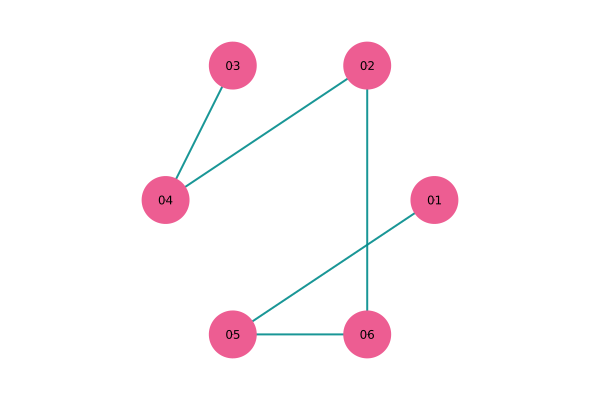

EXCITATION LEVEL: 2


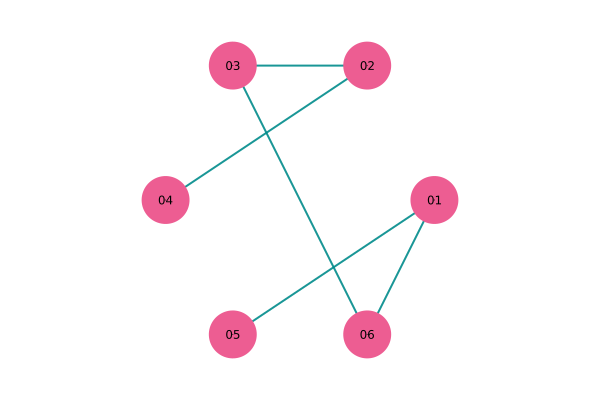

EXCITATION LEVEL: 3


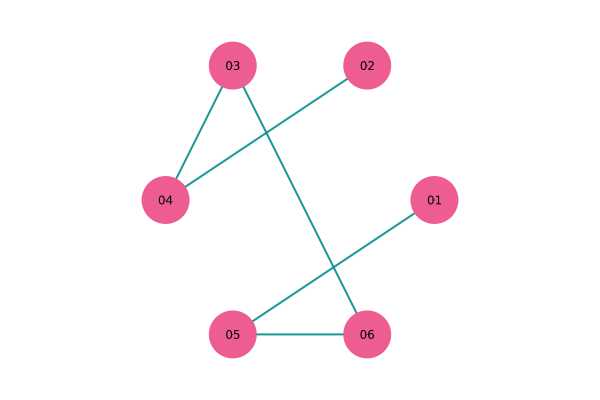

In [82]:
graph_mat_list = []

for (j,ord) in enumerate(tnqe1.ord_list)
    push!(graph_mat_list, GraphMat(ord, directed=false) )
end

for j=1:length(graph_mat_list)
    println("EXCITATION LEVEL: $(j-1)")
    OrbitalGraphPlot(graph_mat_list[j], multiplier=2.0)
end

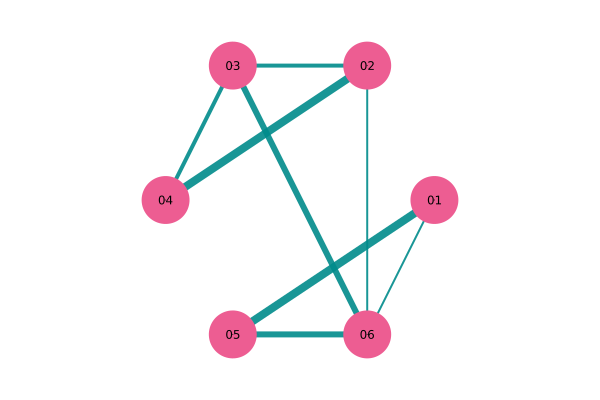

In [83]:
full_graph_mat = sum(graph_mat_list)

OrbitalGraphPlot(full_graph_mat, multiplier=2.0)

In [84]:
display(tnqe1.ord_list)

4-element Vector{Vector{Int64}}:
 [4, 2, 3, 6, 5, 1]
 [3, 4, 2, 6, 5, 1]
 [4, 2, 3, 6, 1, 5]
 [2, 4, 3, 6, 5, 1]

In [85]:
M = tnqe1.mparams.M

for i=1:M, j=1:(M-i)
    println(maxlinkdim(tnqe1.perm_ops[i][j]))
end

16
16
16
16
16
16


In [86]:
PrintFSWAPNetworks!(tnqe1)



###### 1-2 ######

4---x-3
    |  
2-x-x-4
  |    
3-x---2
       
6-----6
       
5-----5
       
1-----1


###### 1-3 ######

4---4
     
2---2
     
3---3
     
6---6
     
5-x-1
  |  
1-x-5


###### 1-4 ######

4-x-2
  |  
2-x-4
     
3---3
     
6---6
     
5---5
     
1---1


###### 2-3 ######

3-x---4
  |    
4-x-x-2
    |  
2---x-3
       
6-----6
       
5-x---1
  |    
1-x---5


###### 2-4 ######

3-x---x-2
  |   |  
4-x-x-x-4
    |    
2---x---3
         
6-------6
         
5-------5
         
1-------1


###### 3-4 ######

4-x-2
  |  
2-x-4
     
3---3
     
6---6
     
1-x-5
  |  
5-x-1


In [87]:
CountNonZeros(tnqe1.psi_list)

186

In [147]:
final_ord = randperm(tnqe1.chem_data.N_spt)

println(final_ord)

sum_mps = SumMPS(tnqe1, final_ord=final_ord)

orthogonalize!(sum_mps, 1)
truncate!(sum_mps, maxdim=15)

println(linkdims(sum_mps))

#println(inner(sum_mps', nomps0.ham_list[1], sum_mps) + tnqe1.chem_data.e_nuc)

CountNonZeros([sum_mps])

[3, 2, 5, 4, 1, 6]
[4, 15, 15, 15, 4]


183

In [85]:
re_dmrg = dmrg(nomps0.ham_list[1], sum_mps, nsweeps=10, noise=(1e-2,1e-2,1e-3,1e-4,1e-5,1e-6), maxdim=15)[2]

println(inner(re_dmrg', nomps0.ham_list[1], re_dmrg) + tnqe1.chem_data.e_nuc)

After sweep 1 energy=-8.326945248072489  maxlinkdim=15 maxerr=5.35E-03 time=3.142
After sweep 2 energy=-8.326971957650027  maxlinkdim=15 maxerr=5.08E-03 time=0.254


LoadError: InterruptException:

In [86]:
swap_prob = 0.5

[Int(floor(swap_prob*randexp()[1])) for k=1:5]

5-element Vector{Int64}:
 0
 0
 0
 0
 0

In [87]:
normalize

normalize (generic function with 7 methods)

In [88]:
using Random

In [89]:
maximum.(randn(10))

10-element Vector{Float64}:
 -0.18186550764251433
  0.03297324176187275
 -0.25176047385343153
 -0.9544608585945676
  0.4437485893999062
  1.8620689693999553
 -1.3254827485261471
  0.8130826544591213
 -1.1836307500947105
  0.14299915264901605

In [90]:
collect(6:(-1):7)

Int64[]

In [91]:
rand((1,2))

2